In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import xtcav.Utils
from xtcav import Constants
import scipy.interpolate
import math
import time
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from scipy.io import loadmat
import xtcav.ClusteringUtils as cu
plt.style.use('seaborn-notebook')

## Genesis Data

(-0.5, 499.5)

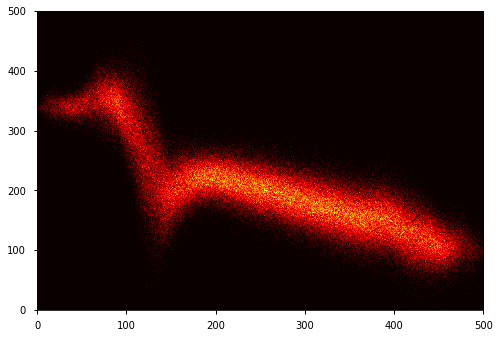

In [13]:
test = loadmat("ML_struct_mat_1_242/ML_data_struct_1.mat")        
test_off = test["Las_OFF_beam_phase_space_H"].astype(np.float32)/np.sum(test["Las_OFF_beam_phase_space_H"].astype(np.float32))
test_on = test["Las_ON_beam_phase_space_H"].astype(np.float32)/np.sum(test["Las_ON_beam_phase_space_H"].astype(np.float32))
plt.imshow(test_off, cmap='hot', interpolation='nearest', aspect='auto')
plt.ylim(plt.ylim()[::-1])

(-0.5, 499.5)

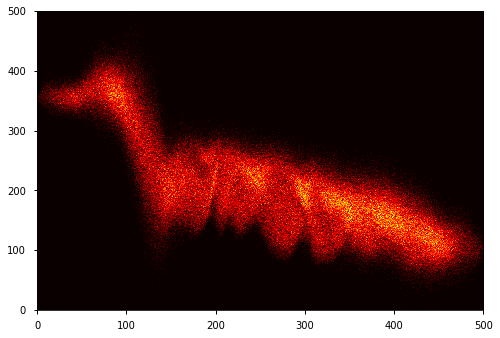

In [14]:
plt.imshow(test_on, cmap='hot', interpolation='nearest', aspect='auto')
plt.ylim(plt.ylim()[::-1])

In [2]:
defaultSS = xtcav.Utils.ShotToShotParameters(ebeamcharge=0.0796590834624, dumpecharge=3.01628324550712e-11, xtcavrfamp=70.0509262084961, xtcavrfphase=-88.50161743164062, xrayenergy=0, unixtime=6496260206392366315, fiducial=6828, valid=1)

In [11]:
## Get Genesis data and format for xtcav code
images_on = []
images_off = []
current = []
time = []
image_profiles_off = []
image_profiles_on = []
power = []
for folder, rang in [('ML_struct_mat_1_242',range(1,243))]:#, ('ML_struct_mat_243_424', range(243,425))]:
    for i in rang:
        try:
            f = folder+"/ML_data_struct_"+str(i)+".mat"
            mat = loadmat(f)  
            #may need to flip the phase space about the X axis so its in the right orientation
            lasing_off = mat["Las_OFF_beam_phase_space_H"].astype(np.float32)/np.sum(mat["Las_OFF_beam_phase_space_H"])    
            lasing_on = mat["Las_ON_beam_phase_space_H"].astype(np.float32)/np.sum(mat["Las_ON_beam_phase_space_H"])
        except:
            print "Nothing for example ", i
            continue
        #level = 45
        #lasing_on = cv2.GaussianBlur(lasing_on, (level, level), 0)
        images_on.append(lasing_on)
        #lasing_off = cv2.GaussianBlur(lasing_off, (level, level), 0)
        images_off.append(lasing_off)

        current.append(mat['final_beam_current'][0].astype(np.float32))
        time.append(mat['time'][0])
        po = mat['power'][0].astype(np.float32)
        #blur true power profile
#         sig = int(float(len(po))/lasing_off.shape[0]*level)
#         sig = sig +1 if sig %2 == 0 else sig
#         po = cv2.GaussianBlur(po, (sig,sig), 0).flatten()
#         po[po < 1e-5] = 0
        power.append(po)

        # format genesis data for use by xtcav code
        # lasing off profile
        lasing_off_formatted = np.zeros((1,lasing_off.shape[0],lasing_off.shape[1]))
        lasing_off_formatted[0,:,:]=lasing_off 
        roi = xtcav.Utils.ROIMetrics(lasing_off.shape[1], 0, 
                lasing_off.shape[0], 0, 
                x=np.arange(0, lasing_off.shape[1]), 
                y=np.arange(0, lasing_off.shape[0]))
        im_stat=xtcav.Utils.getImageStatistics(lasing_off_formatted, roi)
        xfs = mat["Las_OFF_beam_phase_space_XY"][:,0]
        #xfs = mat["Las_ON_beam_phase_space_XY"][:,0] if xfs[0] == 0 else xfs
        yMeV = mat["Las_OFF_beam_phase_space_XY"][:,1] 
        xfsPerPix = xfs[1] - xfs[0]
        yMeVPerPix = yMeV[1]- yMeV[0]
        pu = xtcav.Utils.PhysicalUnits(xfs, yMeV, xfsPerPix, yMeVPerPix)
        ss = defaultSS._replace(dumpecharge = np.sum(current[-1]*xfsPerPix*1e-15))
        image_profiles_off.append(xtcav.Utils.ImageProfile(im_stat, roi, ss, pu))
        
        #lasing on profile
        lasing_on_formatted = np.zeros((1,lasing_on.shape[0],lasing_on.shape[1]))
        lasing_on_formatted[0,:,:] = lasing_on 
        roi = xtcav.Utils.ROIMetrics(lasing_on.shape[1], 0, 
                lasing_on.shape[0], 0, 
                x=np.arange(0, lasing_on.shape[1]), 
                y=np.arange(0, lasing_on.shape[0]))
        im_stat=xtcav.Utils.getImageStatistics(lasing_on_formatted, roi)
        xfs = mat["Las_ON_beam_phase_space_XY"][:,0]
        yMeV = mat["Las_ON_beam_phase_space_XY"][:,1] 
        xfsPerPix = xfs[1] - xfs[0]
        yMeVPerPix = yMeV[1]-yMeV[0]
        pu = xtcav.Utils.PhysicalUnits(xfs, yMeV, xfsPerPix, yMeVPerPix)
        ss2 = ss._replace(xrayenergy = np.sum(power[-1]*xfsPerPix)*1e-6)
        image_profiles_on.append(xtcav.Utils.ImageProfile(im_stat, roi, ss2, pu))
    
num_profiles = len(images_on)

In [12]:
grouped,_ = xtcav.Utils.averageXTCAVProfilesGroups(image_profiles_off)

Averaging lasing off profiles into  17  groups.


### Sample images

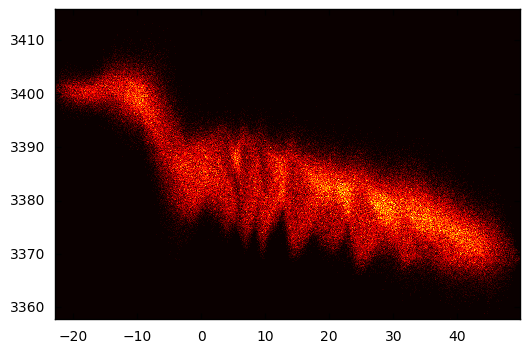

In [5]:
example=20
pu = image_profiles_on[example].physical_units
limits = (pu.xfs[0],pu.xfs[-1],pu.yMeV[0],pu.yMeV[-1])
plt.imshow(images_on[example][::-1], cmap='hot', interpolation='nearest', aspect='auto', extent=limits)


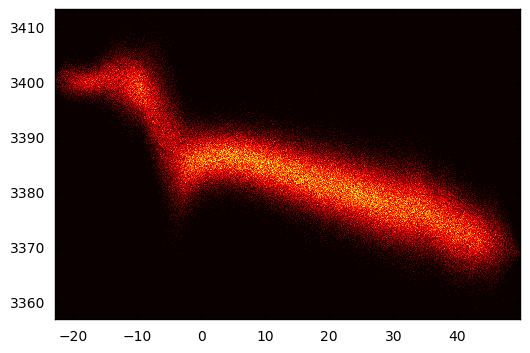

In [6]:
pu = image_profiles_off[example].physical_units
limits = (pu.xfs[0],pu.xfs[-1],pu.yMeV[0],pu.yMeV[-1])
plt.imshow(images_off[example][::-1], cmap='hot', interpolation='nearest', aspect='auto', extent=limits)

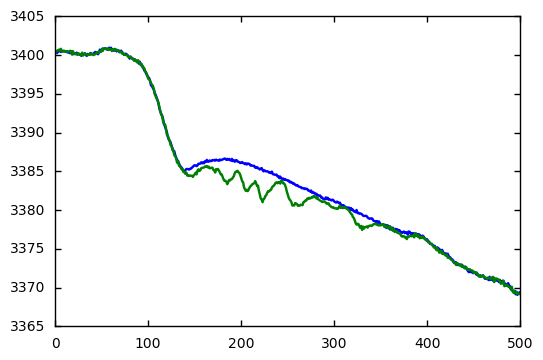

In [7]:
#Plot center of mass
xProfile = np.sum(images_off[example], axis=0)
yProfile = np.sum(images_off[example], axis=1)
plt.plot(np.dot(np.transpose(images_off[example]),image_profiles_off[example].physical_units.yMeV)/xProfile)
xProfile = np.sum(images_on[example], axis=0)
yProfile = np.sum(images_on[example], axis=1)
plt.plot(np.dot(np.transpose(images_on[example]),image_profiles_on[example].physical_units.yMeV)/xProfile)

In [15]:
example = 12
processed_image_opt = xtcav.Utils.processLasingSingleShot(image_profiles_on[example], grouped)
processed_image_opt.powerAgreement

array([ 0.77325358])

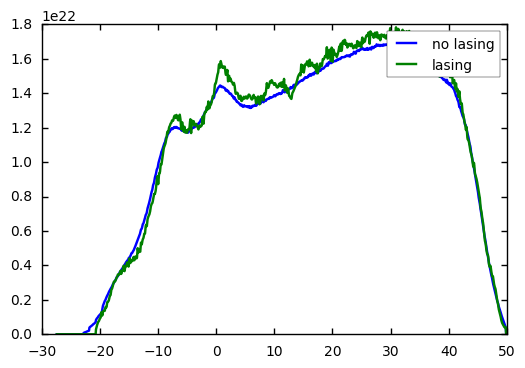

In [16]:
a, = plt.plot(processed_image_opt.t, processed_image_opt.nolasingECurrent[0], label = "no lasing")
b, = plt.plot(processed_image_opt.t, processed_image_opt.lasingECurrent[0], label = 'lasing')
l = plt.legend(handles=[a,b])

### Error Calculations

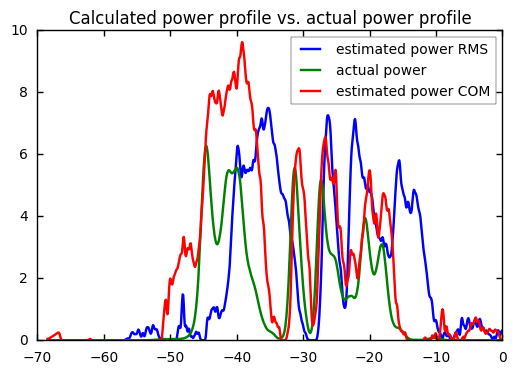

In [32]:
import cv2
offset = 16 # since power profiles are on different time scales, we have to offset the time axis to get them to line up
interp=scipy.interpolate.interp1d(processed_image_opt.t + np.mean(time[example]) - np.mean(processed_image_opt.t),processed_image_opt.powerERMS[0],kind='linear',fill_value=0,bounds_error=False,assume_sorted=True)  #Interpolation to master time
power_opt1 = interp(time[example])
power_opt1 = cv2.GaussianBlur(power_opt1, (7,7), 0).flatten()

interp=scipy.interpolate.interp1d(processed_image_opt.t + np.mean(time[example]) - offset,processed_image_opt.powerECOM[0],kind='linear',fill_value=0,bounds_error=False,assume_sorted=True)  #Interpolation to master time
power_opt2 = interp(time[example])
power_opt2 = cv2.GaussianBlur(power_opt2, (7,7), 0).flatten()

a, = plt.plot(time[example], power_opt1, label = "estimated power RMS")
b, = plt.plot(time[example], power[example], label = "actual power")
c, = plt.plot(time[example], power_opt2, label = "estimated power COM")
plt.title("Calculated power profile vs. actual power profile")
l = plt.legend(handles=[a,b,c])

In [19]:
from scipy import optimize

def getMin(time1, power1, time2, power2, x):
    interp=scipy.interpolate.interp1d(time2 + x, power2,kind='linear',fill_value=0,bounds_error=False,assume_sorted=True)  #Interpolation to master time
    power2 = interp(time1)
    return dist(power1, power2)

def dist(power1,power2):
    power2 = power2*np.sum(power1)/np.sum(power2)
    square_dist = np.power(power1 - power2, 2)
    return np.sum(square_dist)


In [20]:
algs= ['cosine', 'kmeans', 'l1', 'old','hierarchical']

In [25]:
%%capture
# Average distance from true power profile when different number of clusters are used
num_profiles = len(image_profiles_off)
alg_errors = {}
nor_coast = cu.getNorthCoast(images_off)
for alg in algs:
    errors = {}
    for i in [2,5,9,12,20,30,50,100,num_profiles-1]:
        error = 0
        for example in range(num_profiles):
            grouped,_ = xtcav.Utils.averageXTCAVProfilesGroups(image_profiles_off[:example]+image_profiles_off[example+1:], i, method=alg)
            processed_image_opt = xtcav.Utils.processLasingSingleShot(image_profiles_on[example], grouped)
            power_opt = processed_image_opt.powerERMS[0]
            power_opt = cv2.GaussianBlur(power_opt, (7,7), 0).flatten()
            func = lambda x: getMin(time[example], power[example], processed_image_opt.t, power_opt, x)
            test = []
            for method in ['Powell', 'Nelder-Mead', 'BFGS']:
                test.append(optimize.minimize(func, np.mean(time[example]) - np.mean(processed_image_opt.t)-10, method = method).fun)
            assert(not math.isnan(np.nanmin(test)))
            error += np.nanmin(test)/num_profiles

        errors[i] = error
    alg_errors[alg] = errors
    

In [41]:
%%capture 
# ^above line supresses output
# Error when random profile is chosen for comparison
baseline_error = 0
num_iters = 10
for i in range(num_iters):
    for example in range(num_profiles):
        comparison = np.random.randint(0,num_profiles-1)
        grouped,_ = xtcav.Utils.averageXTCAVProfilesGroups([image_profiles_off[comparison]], 1) 
        processed_image_opt = xtcav.Utils.processLasingSingleShot(image_profiles_on[example], grouped)
        power_opt = processed_image_opt.powerERMS[0]
        power_opt = cv2.GaussianBlur(power_opt, (7,7), 0).flatten()
        func = lambda x: getMin(time[example], power[example], processed_image_opt.t, power_opt, x)
        test = []
        for method in ['Powell', 'Nelder-Mead', 'BFGS']:
            test.append(optimize.minimize(func, np.mean(time[example]) - np.mean(processed_image_opt.t)-10, method = method).fun)
        baseline_error += np.nanmin(test)
    baseline_error /= num_profiles

In [57]:
%%capture 
# ^above line supresses output
# Error when random profile is chosen for comparison
n_groups = {}
optimal_groups_error = {}
for alg in algs:
    grouped,n_groups[alg] = xtcav.Utils.averageXTCAVProfilesGroups(image_profiles_off, method=alg)
    error=0
    for example in range(num_profiles):
        grouped,_ = xtcav.Utils.averageXTCAVProfilesGroups(image_profiles_off[:example]+image_profiles_off[example+1:], n_groups[alg], method = alg)
        processed_image_opt = xtcav.Utils.processLasingSingleShot(image_profiles_on[example], grouped)
        power_opt = processed_image_opt.powerERMS[0]
        power_opt = cv2.GaussianBlur(power_opt, (7,7), 0).flatten()
        func = lambda x: getMin(time[example], power[example], processed_image_opt.t, power_opt, x)
        test = []
        for method in ['Powell', 'Nelder-Mead', 'BFGS']:
            test.append(optimize.minimize(func, np.mean(time[example]) - np.mean(processed_image_opt.t)-10, method = method).fun)
        error += np.nanmin(test)/ num_profiles
    optimal_groups_error[alg] = error

In [ ]:
labels = []
for alg, c in zip(algs, 'rgbcy'):
    lists = sorted(alg_errors[alg].items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    labels.append(plt.plot(x, y, c, label=alg)[0])
    plt.plot(n_groups[alg], optimal_groups_error[alg], c+'o',ms=10,label=alg)[0]
b, = plt.plot(x, [baseline_error]*len(x), 'k',label='baseline error')
lists = sorted(alg_errors['north_coast'].items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
labels.append(plt.plot(x, y, 'm', label='north coast')[0])
plt.ylabel("Average squared distance from actual power")
plt.xlabel("Number of clusters used")
plt.ylim(ymin=0, ymax=1100) 
labels.append(b)
plt.title("Error vs. Number of Clusters used in Lasing Off References")
l = plt.legend(handles=labels, loc="lower right")

### North coast method

In [6]:
def getPercentile(data, percentile=0.9):
    a = np.cumsum(data, axis=0)
    out = np.divide(a, np.sum(data, axis=0), out=np.zeros_like(a), where=np.sum(data, axis=0)!=0)
    test = (out > 1-percentile).argmax(axis=0)
    return test
    
def trimImg(x):
    rows = np.any(x, axis=1)
    cols = np.any(x, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]
    return x[ymin:ymax+1, xmin:xmax+1]

trimmed = np.array([trimImg(f) for f in images_off])
out = np.array([getPercentile(x) for x in trimmed])
arrlens = np.array([len(x) for x in out])
max_len = np.amax(arrlens)
maxes = [np.max(x) for x in out]
max_val = np.amax(maxes)
def padArray(x):
    return np.pad(x, pad_width=((max_len - len(x))/2, int(np.ceil(float(max_len - len(x))/2)) ) , mode="constant", constant_values=max_val+1) 
pad = [padArray(x) for x in out]
newarr = np.vstack(pad)

(416.0, 0.0)

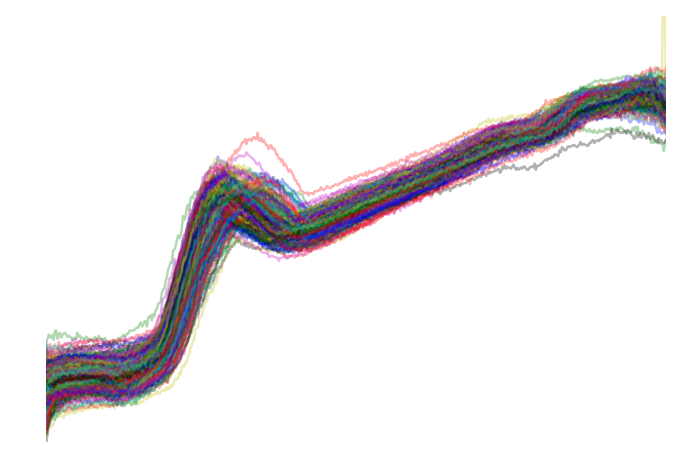

In [11]:
plt.plot(newarr.T, alpha=.3)
plt.axis('tight')
plt.axis('off')
plt.ylim(plt.ylim()[::-1])

In [ ]:
model = AgglomerativeClustering(n_clusters=5, linkage="ward", affinity="euclidean")

rand_sample = newarr
model.fit(rand_sample)
plt.figure()
plt.axes([0, 0, 1, 1])
for l, c in zip(np.arange(model.n_clusters), 'rgbky'):
    plt.plot(rand_sample[model.labels_ == l].T , c=c, alpha=.3)
plt.axis('tight')
plt.axis('off')


In [ ]:
       model = AgglomerativeClustering(n_clusters=10, linkage="ward", affinity="euclidean")
model.fit(newarr)
groups = model.labels_

### Fingerprints
#### We can take the fourier transform of the electron current and use the first few values to get a low dimensional representation of the current. We can then use these values when comparing currents to find the most similar ones for matching lasing off to lasing on profiles

In [102]:
profilesT = grouped.eCurrent[0]
np.std(profilesT[0:5], axis=1)

array([  9.16056902e+20,   9.27966363e+20,   7.82521579e+20,
         7.88903577e+20,   8.22095118e+20])

In [98]:
from sklearn.preprocessing import normalize
test = (profilesT.T - np.mean(profilesT, axis = 1))/np.std(profilesT, axis=1)
test = test.T
dft = np.fft.fft(test)
chosenCols = dft[:,1:10]

In [99]:
import time
t1 = time.time()
print np.corrcoef(chosenCols, chosenCols)[1, 1:5]
print time.time() - t1
t2 = time.time()
print np.corrcoef(profilesT, profilesT)[1, 1:5]
print time.time() - t2

ft = np.argsort(np.corrcoef(chosenCols, chosenCols)[1])[::-1]
norm = np.argsort(np.corrcoef(profilesT, profilesT)[1])[::-1]


[ 1.00000000+0.j          0.97930405-0.19306456j  0.97913237-0.19081945j
  0.97693170-0.19178202j]
0.0367381572723
[ 1.          0.97609983  0.97366866  0.9812808 ]
0.00582385063171


In [100]:
print ft[0:10]
norm[0:10]

[ 88   1 106  19 133  46  87   0  42 129]


array([ 88,   1, 133,  46,   0,  87, 129,  42,  66, 153])

In [40]:
print np.linalg.norm(chosenCols[0] - chosenCols, axis = 1)
np.linalg.norm(profilesT[0] - profilesT[0:5], axis = 1)

[  0.          30.64018396  35.48766929  27.01115034  18.13453174]


array([ 0.        ,  0.02188416,  0.03001281,  0.0218931 ,  0.01475919])